## LIME on Mask R-CNN

In [1]:
import os
import sys
import random
import math
import matplotlib

import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [3]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [4]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

## Create Model and Load Trained Weights

In [5]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [6]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']
print(len(class_names))

81


## Run Object Detection

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scikit_image-0.14.0-py3.6-linux-x86_64.egg/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


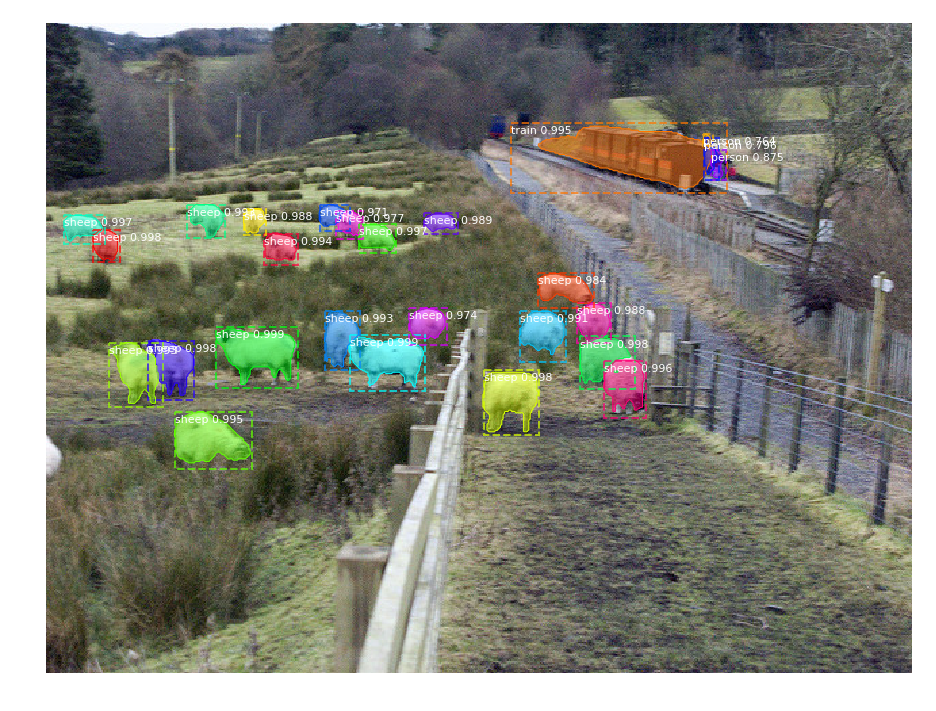

In [29]:
# Load a random images from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
# images = np.array([skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names))),
#                   skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names))),
#                   skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names))),
#                   skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names))),
#                   skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))])

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

### Create The LIME Explanation

In [30]:
explainer = lime_image.LimeImageExplainer()

In [31]:
# Create the Prediction Function for explain_instance
def pred_fn(images):
    _res = model.detect(images)[0]
    _ret = np.zeros((1, 81))
    _scores = _res['scores']
    _class_ids = _res['class_ids']
    for _i in range(_scores.shape[0]):
        _ret[0, _class_ids[_i]] = _scores[_i]
    return _ret

# def pred_fn(imgs):
#     img_results = model.detect(imgs)
#     print("class_ids:\n" + str(img_results[0]['class_ids'])) 
#     print("class scores:\n" + str(img_results[0]['scores']))
#     _labels = np.array(img_results[0]['scores'])
#     _outline = np.zeros((1, 81))
#     _outline[:, img_results[0]['class_ids']] = np.array(np.newaxis, img_results[0]['scores'])
#     return _outline

# def pred_fn2(img):
#     molded_images, image_metas, windows = model.mold_inputs([img])
#     image_shape = molded_images[0].shape
#     anchors = model.get_anchors(image_shape)
#     anchors = np.broadcast_to(anchors, (model.config.BATCH_SIZE,) + anchors.shape)

    # detections, mrcnn_class, mrcnn_bbox, mrcnn_mask, rpn_rois, rpn_class, rpn_bbox
#     detections, _, _, mrcnn_mask, _, _, _ = model.keras_model.predict([molded_images, image_metas, anchors], verbose=0)
#     print(detections[0, :10, 4:]

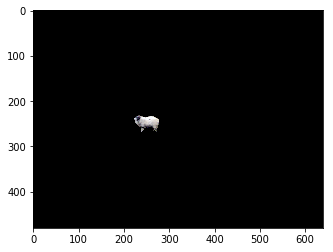

In [32]:
# Regions of Interest

# Num masks = r['masks'].shape[2]
im = image.copy()
im[np.where(r['masks'][:, :, 0] == False)] = 0
plt.imshow(im)

# masks = []
# for i in r['masks'].shape[2]:
#     im = image.copy()
#     im[np.where(r['masks'][:, :, 0] == False)] = 0
#     masks.append(im)

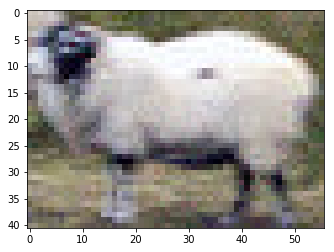

In [33]:
bounding_box_subimages = []

for y1, x1, y2, x2 in r['rois']:
    sub_image = image[[[y] for y in range(y1, y2)], [range(x1, x2)]]
    bounding_box_subimages.append(sub_image)

plt.imshow(bounding_box_subimages[0])

In [34]:
%%time

im = bounding_box_subimages[0]
explanation = explainer.explain_instance(im, pred_fn, top_labels=5, hide_color=0, num_samples=10, batch_size=1)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scikit_image-0.14.0-py3.6-linux-x86_64.egg/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Data:
[[1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]]
Labels:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.92230362 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.  

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.6207013295825596e-17 / 1.1102230246251565e-16
  RuntimeWarning)


In [64]:
from skimage.segmentation import mark_boundaries
from skimage.segmentation import find_boundaries

[16, 80, 20, 22, 23]
['cat', 'toothbrush', 'cow', 'bear', 'zebra']
class_id of the true label -- sheep -- is 19


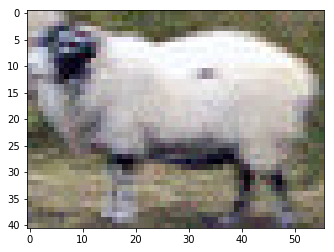

In [59]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=1000, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

print(explanation.top_labels)
print([class_names[l] for l in explanation.top_labels])

tru_label = class_names[r['class_ids'][0]]
print("class_id of the true label -- " + tru_label + " -- is " + str(class_names.index(tru_label)))

### Superpixel Tests

In [93]:
import time


class SubPlotter:
    
    def __init__(self, cols=3, rows=1):
        self.i = 0
        self.start = time.time()
#         self.prediction = 'American_black_bear'
        self.fig, self.axeslist = plt.subplots(ncols=cols, nrows=rows, figsize=(5 * cols, 5 * rows))
        
    def plot_row(self, expl, img, gamma):
        # Display the altered image
        _sp = self.axeslist.ravel()[self.i]
        _sp.imshow(img, cmap=plt.gray())
        _sp.set_title("gamma: " + str(round(gamma, 2)))
        _sp.set_axis_off()
        self.i += 1
        
        # Display the altered image's superpixel mapping
        outline = find_boundaries(expl.segments)
        print("num_superpixels: " + str(len(expl.segments)))
        c = img.copy()
        c[outline] = (0, 0, 0)
        _sp = self.axeslist.ravel()[self.i]
        _sp.imshow(c, cmap=plt.gray())
        _sp.set_title("gamma: " + str(round(gamma, 2)) + ", superpixel map")
        _sp.set_axis_off()
        self.i += 1
        
        # Display superpixel contribution ins altered image
        temp, mask = expl.get_image_and_mask(expl.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
        _sp = self.axeslist.ravel()[self.i]
        _sp.imshow(mark_boundaries(temp, mask), cmap=plt.gray())
        _sp.set_title("gamma: " + str(round(gamma, 2)) + ", contrib")
        _sp.set_axis_off()
        self.i += 1
        
    def print_preds(self, alter_image, gamma):
        preds = inet_model.predict(np.array([alter_image]))
        tup = decode_predictions(preds)[0][0]
        self.prediction = tup[1]
        print("\ngamma = " + str(gamma))
        for x in decode_predictions(preds)[0]:
            print(x)
        
    def end(self):
        plt.tight_layout()
        plt.show()
        end = time.time()
        diff = end - self.start
        print("Cell ran for " + str(diff) + " seconds! (" + str(diff / 60) + " mins)")

num_superpixels: 41


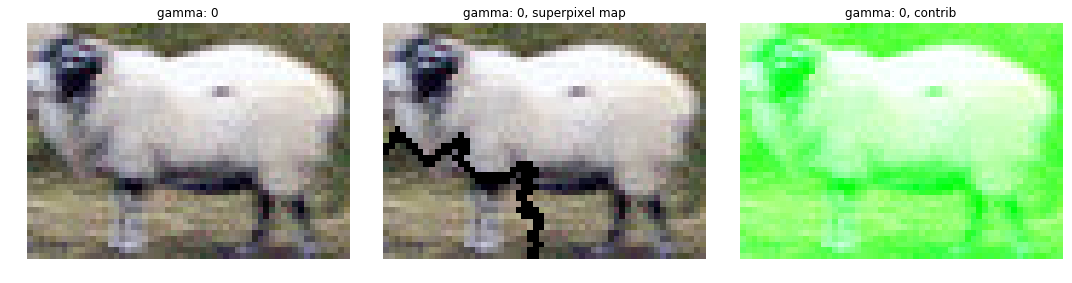

Cell ran for 0.2851223945617676 seconds! (0.004752039909362793 mins)


In [94]:
sp = SubPlotter()
alter_image = im.copy()
sp.plot_row(explanation, alter_image, 0)
sp.end()

### Scratched Trash Code

### 2nd Trash Dump

#### Following: https://github.com/michaeltu1/Mask_RCNN/blob/master/samples/coco/inspect_model.ipynb